# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

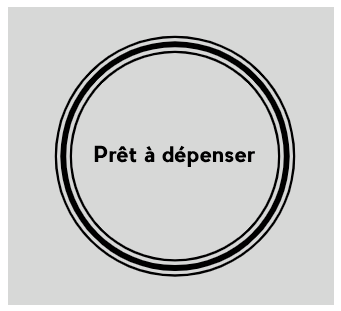

 # <span class='bg-primary'>P7_01_06 - DASHBOARD</span>

Ce notebook traite de la préparation des différents champs et des graphiques du jeu de test pour affichage dans le dashboard.

En particulier :
- **jeu de test** : récupération des champs à afficher dans le dashboard sous une forme compréhensible (ex : âge en années plutôt qu'en nombre de jour, sexe en Féminin/Masculin plutôt que 0/1).
- **interprétabilité/transparence** :
    - récupération des 10 variables les plus importantes pour créer des graphiques pour chacune des ces variables en comparant les résultats des défaillants/non défaillant, de la moyenne global sur tous les clients pour situer la position du client à qui on accordera ou non le prêt.
    - récupération des 10 voisins les plus proches sur ces 10 variables pour le situer parmi ces 10 voisins ceux qui ont été défaillants ou non.
    - situer le patient parmi les défaillants ou non défaillants sur les variables âge, sexe, catégorie socio-professionnelle, revenus, montant du crédit, durée du crédit...

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

In [2]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import pickle
from collections import Counter

# Librairies personnelles
import outils_data
import outils_model
import outils_preprocessing

# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Modèle
import sklearn
from sklearn.neighbors import KNeighborsClassifier

# Standardisation
from sklearn.preprocessing import StandardScaler

# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Seaborn               : ' + sns.__version__)
print('Scikit-learn          : ' + sklearn.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils modélisation   : ' + outils_model.__version__)
print('Outils préprocessing  : ' + outils_preprocessing.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Matplotlib            : 3.3.4
Seaborn               : 0.11.0
Scikit-learn          : 0.23.2
Outils dataframe      : 0.0.4
Outils modélisation   : 0.0.1
Outils préprocessing  : 0.0.0
Lancé le           : 2021-08-16T08:33:08.363541


In [3]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Initialisation (test/meilleur modèle)</span>

<span style='background:Moccasin'>**Chargement du jeu de données du train set sans pré-processing**</span>

In [4]:
application_train = pd.read_csv('../data/application_train.csv')
application_train.shape

(307511, 122)

In [135]:
# Correction valeurs aberrantes
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = 0

In [136]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train = \
    application_train[application_train['CODE_GENDER'] != 'XNA']
application_train.shape

(307507, 122)

<span style='background:Moccasin'>**Chargement du jeu de données du test set sans pré-processing**</span>

In [151]:
application_test = pd.read_csv('../data/application_test.csv')
application_test.shape

(48744, 121)

In [152]:
# Correction valeurs aberrantes
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                  == 365243] = 0

<span style='background:Moccasin'>**Chargement du jeu de données du train set issu du pré-processing et de la feature sélection**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [5]:
fic_sav_train_set_sans = \
    '../sauvegarde/features-selection/train_set_sans_var_magique.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set = pickle.load(df_appli_train_set_sans)
train_set.shape

(307507, 108)

<span style='background:Moccasin'>**Chargement du jeu de données du test set issu du pré-processing et de la feature sélection**</span>

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [6]:
fic_sav_test_set_sans = \
    '../sauvegarde/features-selection/test_set_sans_var_magique.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set = pickle.load(df_appli_test_set_sans)
test_set.shape

(48744, 107)

<span style='background:Moccasin'>**Chargement du meilleur modèle LightGBM**</span>

In [7]:
# Chargement du meilleur modèle
fic_best_model = '../sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.65731418761953,
               force_col_wise=True, max_depth=9, min_child_samples=96,
               min_child_weight=0.5685528790757488, num_leaves=13,
               objective='binary', reg_alpha=1.7033609851586964e-06,
               reg_lambda=0.012745771755334187, subsample=0.8190208924749053,
               subsample_freq=1, verbosity=-1)

## <span style='background:Thistle'>3. Scoring (prédictions/Probabilités)</span>

Le meilleur modèle entraîné sur le jeu d'entraînement est maintenant opérationnel pour effectuer des prédictions et calculer les probabiltés du score de chacun des clients du jeu de test fourni pour Home Crédit.

In [8]:
# Copie du jeu de test
test = test_set.copy(deep=True)
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = test['SK_ID_CURR']
# Préparation de la matrice à soumettre aux prédictions 
X_test = test.drop('SK_ID_CURR', axis=1)

In [9]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [10]:
# Prédictions pour le client :
# classe 0 : non défaillant, classe 1 : défaillant
y_pred = best_model.predict(X_test)

In [11]:
# Constitution du dataframe pour merge
df_score = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE_CLIENT' : y_pred,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_score.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%
0,100001,0,0.3229,32.3
1,100005,1,0.7506,75.1
2,100013,0,0.2673,26.7


In [12]:
# Ajout des prédictions au dataframe du jeu de test
df_dashboard = df_score.merge(test_set, on='SK_ID_CURR', how='left')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CREDIT_ANNUITY_RATIO,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_INTEREST_SHARE_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,EXT_SOURCE_SUM,INST_PAY_DAYS_PAYMENT_DIFF_MIN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,BUREAU_DAYS_CREDIT_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,FLAGS_DOCUMENTS_SUM,INST_PAY_AMT_INSTALMENT_MIN,ENQ_CREDIT_RATIO,NAME_INCOME_TYPE_WORKING,BUREAU_CREDIT_TYPE_MORTGAGE_MEAN,INST_PAY_DAYS_INSTALMENT_MAX,PREV_APP_AMT_DOWN_PAYMENT_MEAN,POS_CASH_SK_DPD_DEF_MEAN,NAME_FAMILY_STATUS_MARRIED,FLAG_OWN_CAR,PREV_APP_CNT_PAYMENT_MEAN,OWN_CAR_AGE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,INST_PAY_AMT_PAYMENT_DIFF_MEAN,REGION_RATING_CLIENT,NAME_INCOME_TYPE_STATE_SERVANT,YEARS_BEGINEXPLUATATION_AVG,DEF_30_CNT_SOCIAL_CIRCLE,CCB_BALANCE_LIMIT_RATIO_MEAN,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,OCCUPATION_TYPE_CORE_STAFF,EXT_SOURCE_VAR,INST_PAY_NUM_INSTALMENT_VERSION_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,AMT_CREDIT,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,ANNUITY_INCOME_RATIO,CAR_EMPLOYED_RATIO,BUREAU_AMT_CREDIT_SUM_MEAN,INST_PAY_AMT_INSTALMENT_SUM,EXT_SOURCE_3,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,DAYS_ID_PUBLISH,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,EXT_SOURCE_2,CREDIT_GOODS_RATIO,EXT_SOURCE_1,PREV_APP_INTEREST_SHARE_MAX,AMT_ANNUITY,INST_PAY_DAYS_PAYMENT_RATIO_MAX,DAYS_BIRTH,PREV_APP_DAYS_LAST_DUE_MAX,DAYS_EMPLOYED,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CODE_GENDER,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,INST_PAY_DAYS_PAYMENT_RATIO_MIN,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,REGION_POPULATION_RELATIVE,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,BUREAU_DAYS_CREDIT_MAX,DAYS_LAST_PHONE_CHANGE,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,EXT_SOURCE_MAX,INST_PAY_AMT_INSTALMENT_MAX,DAYS_REGISTRATION,POS_CASH_CNT_INSTALMENT_MEAN,INST_PAY_DAYS_INSTALMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,FLAG_WORK_PHONE,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_AMT_DECLINED_SUM,CCB_CNT_DRAWINGS_CURRENT_SUM,PREV_APP_CODE_REJECT_REASON_XAP_MEAN,BUREAU_CREDIT_TYPE_MICROLOAN_MEAN,PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN,FLOORSMAX_AVG,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,INST_PAY_AMT_INSTALMENT_MEAN,APARTMENTS_AVG,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,INCOME_GOODS_DIFF,PREV_APP_INTEREST_RATE_MAX,CREDIT_INCOME_RATIO,PREV_APP_DAYS_DECISION_MAX,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_LOAN_RATE_MEAN,PREV_APP_AMT_ANNUITY_SUM,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,INCOME_EXT_RATIO,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,BUREAU_DAYS_CREDIT_LAST,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,INST_PAY_DAYS_PAYMENT_DIFF_MAX
0,100001,0,0.3229,32.3,27.6719,3951.0000,-1709.0,3951.0000,0.3289,0.7778,1453365.0,0,1,1.7012,-10.0,0.0,-735.000,0.9578,1.0000,0.9578,1,3951.0000,0.0000e+00,1.0,0.0,-1619.0,2520.0,0.7778,1.0,1,8.0000,9.0,1.0,0.0000,2,0.0,0.9731,0.0,0.1145,23.0,3104.4375,0.9578,85240.9297,0.0,0.0833,8.0,0.9951,568800.0,596686.5,0.1523,-0.0039,207623.5781,4.1196e+04,0.1595,122382.6406,-812,4761.0000,0.7896,1.2637,0.7524,0.3289,20560.5,1.0039,-19241,-1619.0,-2328.0,0.2825,0,14.2733,0.0,0.9790,0.2106,0.0188,7.0,-49.0,-1740.0,90.0,0.7896,17397.9004,-5168.0,4.0000,-2916.0,0.0,0,0.3289,1048.5,6.0,1.0,0.0,0.0,0.1250,7.0,5885.1323,0.0660,13.0,0.3000,0.8770,4.2148,-1740.0,-1740.0,7821.0000,0.1661,3951.0000,4.0,846151.5000,7.4297,-320.0,1.1426,1079.8038,36.0
1,100005,1,0.7506,75.1,12.8281,4813.2002,-706.0,4813.2002,0.4385,0.8184,657126.0,0,1,1.2891,-1.0,1.0,-190.625,0.8999,1.0000,0.8999,1,4813.2002,1.3471e-05,1.0,0.0,-466.0,4464.0,0.0000,1.0,1,12.0000,9.0,0.0,0.0000,2,0.0,0.9814,0.0,0.1145,18.0,3718.1250,0.8999,189469.5000,0.0,0.0124,10.0,0.9629,222768.0,568408.5,0.1754,-0.0020,219042.0000,5.6162e+04,0.4329

In [17]:
# Sauvegarde de df_dashboard
fic_sav_df_dashboard ='../sauvegarde/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

## <span style='background:Thistle'>4. Préparation des données informatives</span>

### <span style='background:PowderBlue'>4.1. Informations sur le client</span>

Les données informatives sur le client à rendre disponible et lisible pour le chargé de clientèle :

| Variable | Description | Dans test_set et non transformé? |
| --- | --- | --- |
| <p style='text-align: justify; color:red'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> | Non => à  ajouter |
| <p style='text-align: justify; color:green'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> | Oui |
| <p style='text-align: justify; color:red'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> | Non => à  ajouter |
| <p style='text-align: justify; color:orange'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:orange'>**DAYS_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:green'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> | Oui |
| <p style='text-align: justify; color:red'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:orange'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> | Oui mais transformer '0' en 'Féminin' et '1' en 'Masculin' |

**Récupération des variables manquantes**

In [15]:
df_infos =application_test[['SK_ID_CURR',
                            'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']]
df_infos.head(3)

,SK_ID_CURR,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,99000.0,Married,180000.0,0,Cash loans,Secondary / secondary special,House / apartment,Working
2,100013,202500.0,Married,630000.0,0,Cash loans,Higher education,House / apartment,Working
3,100028,315000.0,Married,1575000.0,2,Cash loans,Secondary / secondary special,House / apartment,Working
4,100038,180000.0,Married,625500.0,1,Cash loans,Secondary / secondary special,House / apartment,Working


In [16]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_dashboard = df_dashboard.merge(df_infos, on='SK_ID_CURR', how='right')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CREDIT_ANNUITY_RATIO,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_INTEREST_SHARE_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,EXT_SOURCE_SUM,INST_PAY_DAYS_PAYMENT_DIFF_MIN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,BUREAU_DAYS_CREDIT_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,FLAGS_DOCUMENTS_SUM,INST_PAY_AMT_INSTALMENT_MIN,ENQ_CREDIT_RATIO,NAME_INCOME_TYPE_WORKING,BUREAU_CREDIT_TYPE_MORTGAGE_MEAN,INST_PAY_DAYS_INSTALMENT_MAX,PREV_APP_AMT_DOWN_PAYMENT_MEAN,POS_CASH_SK_DPD_DEF_MEAN,NAME_FAMILY_STATUS_MARRIED,FLAG_OWN_CAR,PREV_APP_CNT_PAYMENT_MEAN,OWN_CAR_AGE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,INST_PAY_AMT_PAYMENT_DIFF_MEAN,REGION_RATING_CLIENT,NAME_INCOME_TYPE_STATE_SERVANT,YEARS_BEGINEXPLUATATION_AVG,DEF_30_CNT_SOCIAL_CIRCLE,CCB_BALANCE_LIMIT_RATIO_MEAN,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,OCCUPATION_TYPE_CORE_STAFF,EXT_SOURCE_VAR,INST_PAY_NUM_INSTALMENT_VERSION_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,AMT_CREDIT,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,ANNUITY_INCOME_RATIO,CAR_EMPLOYED_RATIO,BUREAU_AMT_CREDIT_SUM_MEAN,INST_PAY_AMT_INSTALMENT_SUM,EXT_SOURCE_3,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,DAYS_ID_PUBLISH,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,EXT_SOURCE_2,CREDIT_GOODS_RATIO,EXT_SOURCE_1,PREV_APP_INTEREST_SHARE_MAX,AMT_ANNUITY,INST_PAY_DAYS_PAYMENT_RATIO_MAX,DAYS_BIRTH,PREV_APP_DAYS_LAST_DUE_MAX,DAYS_EMPLOYED,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CODE_GENDER,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,INST_PAY_DAYS_PAYMENT_RATIO_MIN,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,REGION_POPULATION_RELATIVE,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,BUREAU_DAYS_CREDIT_MAX,DAYS_LAST_PHONE_CHANGE,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,EXT_SOURCE_MAX,INST_PAY_AMT_INSTALMENT_MAX,DAYS_REGISTRATION,POS_CASH_CNT_INSTALMENT_MEAN,INST_PAY_DAYS_INSTALMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,FLAG_WORK_PHONE,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_AMT_DECLINED_SUM,CCB_CNT_DRAWINGS_CURRENT_SUM,PREV_APP_CODE_REJECT_REASON_XAP_MEAN,BUREAU_CREDIT_TYPE_MICROLOAN_MEAN,PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN,FLOORSMAX_AVG,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,INST_PAY_AMT_INSTALMENT_MEAN,APARTMENTS_AVG,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,INCOME_GOODS_DIFF,PREV_APP_INTEREST_RATE_MAX,CREDIT_INCOME_RATIO,PREV_APP_DAYS_DECISION_MAX,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_LOAN_RATE_MEAN,PREV_APP_AMT_ANNUITY_SUM,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,INCOME_EXT_RATIO,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,BUREAU_DAYS_CREDIT_LAST,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,INST_PAY_DAYS_PAYMENT_DIFF_MAX,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,0,0.3229,32.3,27.6719,3951.0000,-1709.0,3951.0000,0.3289,0.7778,1.4534e+06,0,1,1.7012,-10.0,0.0000,-735.000,0.9578,1.0000,0.9578,1,3951.0000,0.0000e+00,1.0,0.0,-1619.0,2520.0,0.7778,1.0,1,8.0000,9.0,1.0,0.0000,2,0.0,0.9731,0.0,0.1145,23.0,3104.4375,0.9578,85240.9297,0.0,0.0833,8.0,0.9951,568800.0,596686.5,0.1523,-0.0039,207623.5781,4.1196e+04,0.1595,122382.6406,-812,4761.0000,0.7896,1.2637,0.7524,0.3289,20560.5,1.0039,-19241,-1619.0,-2328.0,0.2825,0,14.2733,0.0,0.9790,0.2106,0.0188,7.0,-49.0,-1740.0,90.0,0.7896,17397.9004,-5168.0,4.0000,-2916.0,0.0,0,0.3289,1048.5,6.0,1.0000,0.0,0.0,0.1250,7.0,5885.1323,0.0660,13.0000,0.3000,0.8770,4.2148,-1740.0,-1740.0,7821.0000,0.1661,3951.0000,4.0,846151.5000,7.4297,-320.0,1.1426,1079.8038,36.0,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,1,0.7506,75.1,12.8281,4813.2002,-706.0,4813.2002,0.4385,0.8184,6.5713e+05,0,1,1.2891,-1.0,1.0000,-190.625,0.8999,1.

**Modification des dates en années au lieu de jours (positif)**

In [17]:
# Transformer DAYS_BIRTH en années positives
df_dashboard['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_dashboard['DAYS_BIRTH'] / 365)).astype('int8')

In [18]:
# Transformer DAYS_EMPLOYED en années positives
df_dashboard['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_dashboard['DAYS_EMPLOYED'] / 365)).astype('int8')

In [19]:
# Transformer sexe : 0 = Féminin et 1 = Masculin
df_dashboard['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                        for row in df_dashboard['CODE_GENDER']] 

In [20]:
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CREDIT_ANNUITY_RATIO,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_INTEREST_SHARE_MEAN,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,EXT_SOURCE_SUM,INST_PAY_DAYS_PAYMENT_DIFF_MIN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,BUREAU_DAYS_CREDIT_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,INST_PAY_AMT_PAYMENT_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,FLAGS_DOCUMENTS_SUM,INST_PAY_AMT_INSTALMENT_MIN,ENQ_CREDIT_RATIO,NAME_INCOME_TYPE_WORKING,BUREAU_CREDIT_TYPE_MORTGAGE_MEAN,INST_PAY_DAYS_INSTALMENT_MAX,PREV_APP_AMT_DOWN_PAYMENT_MEAN,POS_CASH_SK_DPD_DEF_MEAN,NAME_FAMILY_STATUS_MARRIED,FLAG_OWN_CAR,PREV_APP_CNT_PAYMENT_MEAN,OWN_CAR_AGE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,INST_PAY_AMT_PAYMENT_DIFF_MEAN,REGION_RATING_CLIENT,NAME_INCOME_TYPE_STATE_SERVANT,YEARS_BEGINEXPLUATATION_AVG,DEF_30_CNT_SOCIAL_CIRCLE,CCB_BALANCE_LIMIT_RATIO_MEAN,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,OCCUPATION_TYPE_CORE_STAFF,EXT_SOURCE_VAR,INST_PAY_NUM_INSTALMENT_VERSION_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MEAN,AMT_CREDIT,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,ANNUITY_INCOME_RATIO,CAR_EMPLOYED_RATIO,BUREAU_AMT_CREDIT_SUM_MEAN,INST_PAY_AMT_INSTALMENT_SUM,EXT_SOURCE_3,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,DAYS_ID_PUBLISH,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,EXT_SOURCE_2,CREDIT_GOODS_RATIO,EXT_SOURCE_1,PREV_APP_INTEREST_SHARE_MAX,AMT_ANNUITY,INST_PAY_DAYS_PAYMENT_RATIO_MAX,DAYS_BIRTH,PREV_APP_DAYS_LAST_DUE_MAX,DAYS_EMPLOYED,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CODE_GENDER,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,INST_PAY_DAYS_PAYMENT_RATIO_MIN,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,REGION_POPULATION_RELATIVE,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,BUREAU_DAYS_CREDIT_MAX,DAYS_LAST_PHONE_CHANGE,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,EXT_SOURCE_MAX,INST_PAY_AMT_INSTALMENT_MAX,DAYS_REGISTRATION,POS_CASH_CNT_INSTALMENT_MEAN,INST_PAY_DAYS_INSTALMENT_MIN,AMT_REQ_CREDIT_BUREAU_QRT,FLAG_WORK_PHONE,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_AMT_DECLINED_SUM,CCB_CNT_DRAWINGS_CURRENT_SUM,PREV_APP_CODE_REJECT_REASON_XAP_MEAN,BUREAU_CREDIT_TYPE_MICROLOAN_MEAN,PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN,FLOORSMAX_AVG,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,INST_PAY_AMT_INSTALMENT_MEAN,APARTMENTS_AVG,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,INCOME_GOODS_DIFF,PREV_APP_INTEREST_RATE_MAX,CREDIT_INCOME_RATIO,PREV_APP_DAYS_DECISION_MAX,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_LOAN_RATE_MEAN,PREV_APP_AMT_ANNUITY_SUM,INST_PAY_NUM_INSTALMENT_NUMBER_MAX,INCOME_EXT_RATIO,INST_PAY_DAYS_PAYMENT_DIFF_MEAN,BUREAU_DAYS_CREDIT_LAST,INST_PAY_NUM_INSTALMENT_VERSION_MEAN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,INST_PAY_DAYS_PAYMENT_DIFF_MAX,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,YEAR_BIRTH,YEAR_EMPLOYED,SEXE
0,100001,0,0.3229,32.3,27.6719,3951.0000,-1709.0,3951.0000,0.3289,0.7778,1.4534e+06,0,1,1.7012,-10.0,0.0000,-735.000,0.9578,1.0000,0.9578,1,3951.0000,0.0000e+00,1.0,0.0,-1619.0,2520.0,0.7778,1.0,1,8.0000,9.0,1.0,0.0000,2,0.0,0.9731,0.0,0.1145,23.0,3104.4375,0.9578,85240.9297,0.0,0.0833,8.0,0.9951,568800.0,596686.5,0.1523,-0.0039,207623.5781,4.1196e+04,0.1595,122382.6406,-812,4761.0000,0.7896,1.2637,0.7524,0.3289,20560.5,1.0039,-19241,-1619.0,-2328.0,0.2825,0,14.2733,0.0,0.9790,0.2106,0.0188,7.0,-49.0,-1740.0,90.0,0.7896,17397.9004,-5168.0,4.0000,-2916.0,0.0,0,0.3289,1048.5,6.0,1.0000,0.0,0.0,0.1250,7.0,5885.1323,0.0660,13.0000,0.3000,0.8770,4.2148,-1740.0,-1740.0,7821.0000,0.1661,3951.0000,4.0,846151.5000,7.4297,-320.0,1.1426,1079.8038,36.0,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working,52,6,Féminin
1,100005,1,0.7506,75.1,12.8281,4813.2002,-706.0,4813.2002,0.4385,0.8184,6.5713e+0

### <span style='background:PowderBlue'>4.2. Variables ayant le plus d'importance sur le modèle</span>

- Les variables ayant le plus d'importance sur le modèle constituent les variables à comparer pour situer notre client par rapport à la moyenne des valeurs de ces variables pour tous les clients et comparer ces valeurs avec celles des 10 plus proches voisins qui ont des valeurs similaires à notre client.
- Le but est de tracer un lineplot pour chacune de ces variables déterminantes pour comparer les valeurs du client, les valeurs moyennes sur l'ensemble des clients et les valeurs des 10 plus proches voisins séparés en 2 groupes : défaillant et non-défaillant.

<span style='background:Moccasin'>**Variables à comparer ?**</span>

<span style='background:Lightgreen'>**Features importances**</span>

D'après le notebook sur la modélisation, les 10 variables issus de l'analyse des features importances ayant le plus d'impact sur le meilleur modèle sont :

- [X] CREDIT_ANNUITY RATIO
- [x] EXT_SOURCE_SUM
- [X] INST_PAY_DAYS_PAYMENT_RATIO_MAX
- [X] PREV_APP_INTEREST_SHARE_MAX
- [X] EXT_SOURCE_1
- [X] CREDIT_GOODS_RATIO
- [X] CODE GENDER
- [X] INST_PAY_AMT_INSTALMENT_SUM
- [X] EXT_SOURCE_2
- [X] DAYS_BIRTH
- [X] AMT_ANNUITY
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN

<span style='background:Lightgreen'>**Shapley values globales**</span>

D'après le notebook sur la modélisation, les variables issus de l'analyse des shapley values ayant le plus d'impact (>0.05) sur la prédiction du meilleur modèle sont :
- [X] EXT_SOURCE_SUM
- [X] INST_PAY_DAYS_PAYMENT_RATIO_MAX
- [X] CODE_GENDER
- [X] CREDIT_GOODS_RATIO
- [X] PREV_APP_INTEREST_SHARE_MAX
- [X] EXT_SOURCE_MAX
- [X] CREDIT_ANNUITY_RATIO
- [X] EXT_SOURCE_2
- [X] CAR_EMPLOYED_RATIO
- [X] NAME_EDUCATION_TYPE_HIGHER_EDUCATION
- [X] AMT_ANNUITY
- [X] EXT_SOURCE_3
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN
- [X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN
- [X] BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN
- [X] POSH_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM
- [X] INST_PAY_AMT_INSTALLMENT_SUM
- [X] FLAG_OWN_CAR
- [X] DAYS_ID_PUBLISH
- [X] NAME_FAMILY_STATUS_MARRIED

<span style='background:Lightgreen'>**Combinaison des 2 = variables à zone de risque**</span>

En combinant les variables issus des features importances et celles des shapley values, les variables à fort impact sur le modèle qui permet de comparer notre client et les autres clients sont :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuité de prêt</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN**</p> | <p style='text-align: justify;'>Valeur minimale de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN**</p> | <p style='text-align: justify;'>Valeur moyenne de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit</p> |
| <p style='text-align: justify;'>**BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN**</p> | <p style='text-align: justify;'>Moyenne de du ratio des prêts précédents sur d'autres institution de : la dette actuelle sur le crédit et la limite de crédit actuelle de la carte de crédit</p> |
| <p style='text-align: justify;'>**CAR_EMPLOYED_RATIO**</p> | <p style='text-align: justify;'>Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la date de la demande</p> |
| <p style='text-align: justify;'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**CREDIT_ANNUITY_RATIO**</p> | <p style='text-align: justify;'>Ratio : montant du crédit du prêt / Annuité de prêt</p> |
| <p style='text-align: justify;'>**CREDIT_GOODS_RATIO**</p> | <p style='text-align: justify;'>Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt est accordé / Crédit est supérieur au prix des biens ?</p> |
| <p style='text-align: justify;'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**DAYS_ID_PUBLISH**</p> | <p style='text-align: justify;'>Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt ?</p> |
| <p style='text-align: justify;'>**EXT_SOURCE_1**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_2**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_3**</p> | <p style='text-align: justify;'>Source externe normalisée </p> |
| <p style='text-align: justify;'>**EXT_SOURCE_MAX**</p> | <p style='text-align: justify;'>Valeur maximale des 3 sources externes normalisées (EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3)</p> |
| <p style='text-align: justify;'>**EXT_SOURCE_SUM**</p> | <p style='text-align: justify;'>Somme des 3 sources externes normalisées (EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3) </p> |
| <p style='text-align: justify;'>**FLAG_OWN_CAR**</p> | <p style='text-align: justify;'>Indicateur si le client possède une voiture</p> |
| <p style='text-align: justify;'>**INST_PAY_AMT_INSTALMENT_SUM**</p> | <p style='text-align: justify;'>Somme du montant de l'acompte prescrit des crédits précédents sur cet acompte</p> |
| <p style='text-align: justify;'>**INST_PAY_DAYS_PAYMENT_RATIO_MAX**</p> | <p style='text-align: justify;'>Valeur maximal dans l'historique des précédents crédits remboursés dans Home Crédit du ratio : La date à laquelle le versement du crédit précédent était censé être payé (par rapport à la date de demande du prêt actuel) \ Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation le plus élévé</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Situation de famille</p> |
| <p style='text-align: justify;'>**POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM**</p> | <p style='text-align: justify;'>Somme des contrats actifs au cours du mois</p> |
| <p style='text-align: justify;'>**PREV_APP_INTEREST_SHARE_MAX**</p> | <p style='text-align: justify;'>La valeur maximale de tous les précédents crédit dans d'autres institution : de la durée du crédit multiplié par l'annuité du prêt moins le montant final du crédit</p> |

<span style='background:Moccasin'>**10 plus proches voisins pour ces variables ?**</span>

On applique l'exemple de constitution de la variable magique du kernel kaggle pour récupérer les 10 plus proches voisins pour les variables les plus déterminantes sur la décision client défaillant/non-défaillant.

[Source Kaggle](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821) 

[Source KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors)

**Préparation des données**

In [21]:
# Liste des variables les plus déterminantes
feat_imp = ['AMT_ANNUITY',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
            'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
            'CAR_EMPLOYED_RATIO',
            'CODE_GENDER',
            'CREDIT_ANNUITY_RATIO',
            'CREDIT_GOODS_RATIO',
            'DAYS_BIRTH',
            'DAYS_ID_PUBLISH',
            'EXT_SOURCE_1',
            'EXT_SOURCE_2',
            'EXT_SOURCE_3',
            'EXT_SOURCE_MAX',
            'EXT_SOURCE_SUM',
            'FLAG_OWN_CAR',
            'INST_PAY_AMT_INSTALMENT_SUM',
            'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
            'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
            'NAME_FAMILY_STATUS_MARRIED',
            'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
            'PREV_APP_INTEREST_SHARE_MAX']

In [22]:
# Matrice X - variables les plus déterminantes
X = train_set[feat_imp]

In [23]:
# Standardisation KNN utilise les distances - train set
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns.to_list())
X_std.shape

(307507, 22)

In [24]:
# Vecteur y
# y = df_dashboard['SCORE_CLIENT'].astype('int64')
y = train_set['TARGET']
y.shape

(307507,)

In [25]:
# Matrice X_test - variables les plus déterminantes
X_test = test_set[feat_imp]

In [26]:
# Standardisation KNN utilise les distances - test set
scaler_std = StandardScaler()
X_test_std = scaler_std.fit_transform(X_test)
X_test_std = pd.DataFrame(X_test_std, index=X_test.index,
                          columns=X_test.columns.to_list())
X_test_std.shape

(48744, 22)

In [27]:
# Vecteur y
y_test = df_dashboard['SCORE_CLIENT'].astype('int64')
y_test.shape

(48744,)

<span style='background:Lightgreen'>**10 voisins les plus proches du train set**</span>

In [41]:
# Instanciation du modèle
knn = KNeighborsClassifier(10, n_jobs = -1)

In [42]:
# Entraînement du modèle
knn.fit(X_std, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [65]:
# Sauvegarde du modèle entraîné
fic_knn ='../sauvegarde/dashboard/knn_10_voisins_train.pickle'
with open(fic_knn, 'wb') as f:
    pickle.dump(knn, f, pickle.HIGHEST_PROTOCOL)

In [43]:
# Récupération des index des 10 voisins similaires
liste_index_10_voisins = knn.kneighbors(X_test_std)[1]

In [44]:
# Index des 10 clients voisins dans le train set
df_dashboard['INDEX_10_VOISINS_TRAIN'] = \
    [index for index in liste_index_10_voisins]

In [45]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [Counter(train_set['TARGET'].iloc[index])[1]
     for index in liste_index_10_voisins]

In [46]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT_TRAIN'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT_TRAIN']]

In [47]:
df_dashboard[['SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT_TRAIN']].head(10)

,SCORE_CLIENT,PRED_CLASSE_CLIENT,%_NB_10_VOISINS_DEFAILLANT_TRAIN
0,0.3229,0,20.0
1,0.7506,1,20.0
2,0.2673,0,20.0
3,0.1873,0,0.0
4,0.6179,1,20.0
5,0.3146,0,0.0
6,0.0982,0,0.0
7,0.2937,0,10.0
8,0.1236,0,0.0
9,0.5236,1,0.0


**Constitution du dataframe des voisins pour le dashboard**

In [206]:
df_index_voisins = \
    pd.DataFrame({'ID_CLIENT' : test_set['SK_ID_CURR'],
                  'INDEX_10_VOISINS' : liste_index_10_voisins.tolist()})
df_index_voisins.shape

(48744, 2)

In [ ]:
df_voisin_train = pd.DataFrame({})

In [207]:
# ID_CLIENT entre 100001 et 150000 : 6804 clients
mask = df_index_voisins['ID_CLIENT'] >= 100001 
mask2 = df_index_voisins['ID_CLIENT'] < 150000 
df1 = df_index_voisins[mask & mask2]
df1.shape

(6804, 2)

In [208]:
for id_cli, row in zip(df1['ID_CLIENT'],
                       df1['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

,ID_CLIENT,INDEX_VOISIN,AMT_ANNUITY,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,CAR_EMPLOYED_RATIO,CODE_GENDER,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,DAYS_BIRTH,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MAX,EXT_SOURCE_SUM,FLAG_OWN_CAR,INST_PAY_AMT_INSTALMENT_SUM,INST_PAY_DAYS_PAYMENT_RATIO_MAX,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_FAMILY_STATUS_MARRIED,POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM,PREV_APP_INTEREST_SHARE_MAX,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_FAMILY_STATUS,DAYS_EMPLOYED,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,77677,21609.0,31356.0,104587.8750,0.3222,-0.0018,0.0,30.8125,1.3965,-15678.0,-538.0,0.7534,0.6982,0.2957,0.7534,1.7471,1.0,88719.0312,1.0000,1.0,1.0,11.0,0.1538,135000.0,665892.0,Married,-5107,477000.0,0,Cash loans,Higher education,House / apartment,Working
1,100001,257447,29214.0,50287.5,254271.1562,0.2663,-0.0018,0.0,31.0000,1.1982,-17358.0,-778.0,0.8647,0.6846,0.1830,0.8647,1.7314,1.0,167623.5625,0.9644,1.0,1.0,13.0,0.0870,315000.0,905688.0,Married,-5093,756000.0,0,Cash loans,Higher education,House / apartment,State servant
2,100001,109458,19039.5,66123.0,96661.5000,0.1876,-0.0017,0.0,27.6562,1.1582,-17745.0,-358.0,0.8037,0.6958,0.3047,0.8037,1.8047,1.0,472126.9375,1.0107,1.0,1.0,24.0,0.4551,171000.0,526491.0,Married,-5453,454500.0,0,Cash loans,Higher education,House / apartment,Working
3,100001,212270,35860.5,13500.0,66274.5000,0.6045,-0.0123,0.0,34.1875,1.1455,-17599.0,-639.0,0.7939,0.7363,0.0839,0.7939,1.6143,1.0,888188.3125,1.0186,1.0,1.0,21.0,0.4824,202500.0,1226511.0,Married,-730,1071000.0,1,Cash loans,Higher education,House / apartment,Commercial associate
4,100001,139230,35842.5,12816.0,245472.0000,0.5658,-0.0077,0.0,36.2188,1.1455,-18962.0,-2482.0,0.8213,0.7285,0.1885,0.8213,1.7383,1.0,619353.3750,1.0000,1.0,1.0,15.0,0.2401,225000.0,1298655.0,Married,-1165,1134000.0,0,Cash loans,Higher education,House / apartment,Working


In [214]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [216]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 150000
mask2 = df_index_voisins['ID_CLIENT'] < 200000 
df2 = df_index_voisins[mask & mask2]
df2.shape

(7023, 2)

In [ ]:
for id_cli, row in zip(df2['ID_CLIENT'],
                       df2['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [ ]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 200000
mask2 = df_index_voisins['ID_CLIENT'] < 250000 
df3 = df_index_voisins[mask & mask2]
df3.shape

In [ ]:
for id_cli, row in zip(df3['ID_CLIENT'],
                       df3['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [ ]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 250000
mask2 = df_index_voisins['ID_CLIENT'] < 300000 
df4 = df_index_voisins[mask & mask2]
df4.shape

In [ ]:
for id_cli, row in zip(df4['ID_CLIENT'],
                       df4['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [ ]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 300000
mask2 = df_index_voisins['ID_CLIENT'] < 350000 
df5 = df_index_voisins[mask & mask2]
df5.shape

In [ ]:
for id_cli, row in zip(df5['ID_CLIENT'],
                       df5['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [ ]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 350000
mask2 = df_index_voisins['ID_CLIENT'] < 400000 
df6 = df_index_voisins[mask & mask2]
df6.shape

In [ ]:
for id_cli, row in zip(df6['ID_CLIENT'],
                       df6['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [ ]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 400000
mask2 = df_index_voisins['ID_CLIENT'] < 450000 
df7 = df_index_voisins[mask & mask2]
df7.shape

In [ ]:
for id_cli, row in zip(df7['ID_CLIENT'],
                       df7['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [ ]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ID_CLIENT entre 150000 et 200000 :  clients
mask = df_index_voisins['ID_CLIENT'] >= 450000
mask2 = df_index_voisins['ID_CLIENT'] < 500000 
df8 = df_index_voisins[mask & mask2]
df8.shape

In [ ]:
for id_cli, row in zip(df8['ID_CLIENT'],
                       df8['INDEX_10_VOISINS']):
     for index in row:
            var_imp = train_set.iloc[index]
            info = application_train.iloc[index]
            df_voisin_train = df_voisin_train.append(pd.DataFrame({
                                           'ID_CLIENT': [id_cli],
                                           'INDEX_VOISIN': [index],
                                           'AMT_ANNUITY': [var_imp['AMT_ANNUITY']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']],
                                           'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN': [var_imp['BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN']],
                                           'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN': [var_imp['BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN']],
                                           'CAR_EMPLOYED_RATIO': [var_imp['CAR_EMPLOYED_RATIO']],
                                           'CODE_GENDER': [var_imp['CODE_GENDER']],
                                           'CREDIT_ANNUITY_RATIO': [var_imp['CREDIT_ANNUITY_RATIO']],
                                           'CREDIT_GOODS_RATIO': [var_imp['CREDIT_GOODS_RATIO']],
                                           'DAYS_BIRTH': [var_imp['DAYS_BIRTH']],
                                           'DAYS_ID_PUBLISH': [var_imp['DAYS_ID_PUBLISH']],
                                           'EXT_SOURCE_1': [var_imp['EXT_SOURCE_1']],
                                           'EXT_SOURCE_2': [var_imp['EXT_SOURCE_2']],
                                           'EXT_SOURCE_3': [var_imp['EXT_SOURCE_3']],
                                           'EXT_SOURCE_MAX': [var_imp['EXT_SOURCE_MAX']],
                                           'EXT_SOURCE_SUM': [var_imp['EXT_SOURCE_SUM']],
                                           'FLAG_OWN_CAR': [var_imp['FLAG_OWN_CAR']],
                                           'INST_PAY_AMT_INSTALMENT_SUM': [var_imp['INST_PAY_AMT_INSTALMENT_SUM']],
                                           'INST_PAY_DAYS_PAYMENT_RATIO_MAX': [var_imp['INST_PAY_DAYS_PAYMENT_RATIO_MAX']],
                                           'NAME_EDUCATION_TYPE_HIGHER_EDUCATION': [var_imp['NAME_EDUCATION_TYPE_HIGHER_EDUCATION']],
                                           'NAME_FAMILY_STATUS_MARRIED ': [var_imp['NAME_FAMILY_STATUS_MARRIED']],
                                           'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM': [var_imp['POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM']],
                                           'PREV_APP_INTEREST_SHARE_MAX': [var_imp['PREV_APP_INTEREST_SHARE_MAX']],
                                           'AMT_INCOME_TOTAL': [info['AMT_INCOME_TOTAL']],
                                           'AMT_CREDIT': [info['AMT_CREDIT']],
                                           'NAME_FAMILY_STATUS': [info['NAME_FAMILY_STATUS']],
                                           'DAYS_EMPLOYED': [info['DAYS_EMPLOYED']],
                                           'AMT_GOODS_PRICE': [info['AMT_GOODS_PRICE']],
                                           'CNT_CHILDREN': [info['CNT_CHILDREN']],
                                           'NAME_CONTRACT_TYPE': [info['NAME_CONTRACT_TYPE']],
                                           'NAME_EDUCATION_TYPE': [info['NAME_EDUCATION_TYPE']],
                                           'NAME_HOUSING_TYPE': [info['NAME_HOUSING_TYPE']],
                                           'NAME_INCOME_TYPE': [info['NAME_INCOME_TYPE']]
                                           }), ignore_index=True)         
df_voisin_train.head()

In [ ]:
# Sauvegarde de df_voisin_train
with open(fic_sav_df_voisin_train, 'wb') as f:
    pickle.dump(df_voisin_train, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def bip1():
    import winsound
    frequency = 2500  # max 2500 Hertz
    duration = 2000  # max 1000 ms
    winsound.Beep(frequency, duration)

In [212]:
bip1()

In [154]:
# Ajout YEAR_BIRTH : DAYS_BIRTH en années positives
df_voisin_train['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_voisin_train['DAYS_BIRTH'] / 365)).astype('int8')

In [155]:
# Ajout YEAR_EMPLOYED : DAYS_EMPLOYED en années positives
df_voisin_train['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_voisin_train['DAYS_EMPLOYED'] / 365)).astype('int8')

In [156]:
# Ajout SEXE : de CODE_GENDER : 0 = Féminin et 1 = Masculin
df_voisin_train['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                           for row in df_voisin_train['CODE_GENDER']] 

**Réduction de la taille des variables pour optimisation mémoire**

In [157]:
df_voisin_train =outils_preprocessing.reduce_mem_usage(df_voisin_train)

-------------------------------------------------------------------------------
Memory usage du dataframe: 0.01 MB
Memory usage après optimization: 0.00 MB
Diminution de 54.8%
-------------------------------------------------------------------------------


**Sauvegarde du dataframe des voisins dans le train set**

In [158]:
# Sauvegarde des scores des best models du train_set
fic_sav_df_voisins_train = \
    '../sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisins_train, 'wb') as f:
    pickle.dump(df_voins_train, f, pickle.HIGHEST_PROTOCOL)

<span style='background:Lightgreen'>**10 voisins les plus proches du test_set**</span>

- Récupération des 10 plus proches voisins de notre client pour calculer leur score moyen qui alimentera le delta de la jauge et permettra de comparer le score de notre client au score moyen prédits ainsi que le nombre de défaillants prédits pour ces 10 clients voisins.

In [28]:
# Instanciation du modèle
knn_test = KNeighborsClassifier(10, n_jobs = -1)

In [29]:
# Entraînement du modèle
knn_test.fit(X_test_std, y_test)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [60]:
# Sauvegarde du modèle entraîné
fic_knn_test ='../sauvegarde/dashboard/knn_10_voisins_test.pickle'
with open(fic_knn_test, 'wb') as f:
    pickle.dump(knn_test, f, pickle.HIGHEST_PROTOCOL)

In [31]:
# Récupération des index des 10 voisins similaire
liste_index_10_voisins_test = knn_test.kneighbors(X_test_std)[1]

In [34]:
# Index des 10 clients voisins
df_dashboard['INDEX_10_VOISINS_MEAN_TEST'] = \
    [index for index in liste_index_10_voisins_test]

In [35]:
# Index des 10 clients voisins
df_dashboard['SCORE_10_VOISINS_MEAN_TEST'] = \
    [df_dashboard['SCORE_CLIENT'].iloc[index].mean()
     for index in liste_index_10_voisins_test]

In [36]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT_TEST'] = \
    [Counter(df_dashboard['PRED_CLASSE_CLIENT'].iloc[index])[1]
     for index in liste_index_10_voisins_test]

In [37]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT_TEST'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT_TEST']]

In [38]:
df_dashboard[['SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT_TEST']].head(10)

,SCORE_CLIENT,PRED_CLASSE_CLIENT,%_NB_10_VOISINS_DEFAILLANT_TEST
0,0.3229,0,0.0
1,0.7506,1,90.0
2,0.2673,0,0.0
3,0.1873,0,0.0
4,0.6179,1,80.0
5,0.3146,0,0.0
6,0.0982,0,0.0
7,0.2937,0,30.0
8,0.1236,0,0.0
9,0.5236,1,60.0


## <span style='background:Thistle'>5. Préparation des graphiques</span>

### <span style='background:PowderBlue'>5.1. Informations générales</span>

<span style='background:Moccasin'>**Client courant**</span>

Les données informatives à afficher une fois le client sélectionner :

- sur les traits stricts du client :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**YEAR_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**SEXE**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> |
| <p style='text-align: justify;'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> |
| <p style='text-align: justify;'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> |
| <p style='text-align: justify;'>**YEAR_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> |
| <p style='text-align: justify;'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> |

- sur le prêt :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> |
| <p style='text-align: justify;'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> |
| <p style='text-align: justify;'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> |
| <p style='text-align: justify;'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> |

**Traits stricts du client**

In [79]:
# Traits stricts du client
df_info_client = df_dashboard[['YEAR_BIRTH', 'SEXE', 'NAME_FAMILY_STATUS',
                               'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                               'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                               'AMT_INCOME_TOTAL']]

In [91]:
df_info_client = df_info_client.rename(columns = {
     'YEAR_BIRTH' : 'Âge (ans)',
     'SEXE' : 'Sexe',
     'NAME_FAMILY_STATUS' : 'Statut familial',
     'CNT_CHILDREN' : 'Nbre enfants',
     'NAME_EDUCATION_TYPE' : 'Niveau éducation',
     'NAME_INCOME_TYPE' : 'Type revenu',
     'YEAR_EMPLOYED' : 'Ancienneté emploi',
     'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_client.head(3)

,Âge (ans),Sexe,Statut familial,Nbre enfants,Niveau éducation,Type revenu,Ancienneté emploi,Revenus ($)
0,52,Féminin,Married,0,Higher education,Working,6,135000.0
1,49,Masculin,Married,0,Secondary / secondary special,Working,12,99000.0
2,54,Masculin,Married,0,Higher education,Working,12,202500.0


**Informations sur la demande de prêt du client**

In [83]:
# Informations sur la demande prêt
df_pret_client = df_dashboard[['NAME_CONTRACT_TYPE', 'AMT_CREDIT',
                               'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                               'NAME_HOUSING_TYPE']]

In [169]:
df_pret_client = df_pret_client.rename(columns = {
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'ontant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_client.head(3)

,Type de prêt,Montant du crédit ($),Annuités ($),Montant du bien ($),Type de logement
0,Cash loans,568800.0,20560.5,450000.0,House / apartment
1,Cash loans,222768.0,17370.0,180000.0,House / apartment
2,Cash loans,663264.0,69777.0,630000.0,House / apartment


**10 voisins les plus proches du test set**

- Ajout du score prévisionnel moyen des 10 voisins les plus proches pour les variables les plus importantes à afficher dans la jauge sous le score de notre client.
- Ce score moyen permet de savoir comment se situe notre client parmi ses 10 voisins. Par exemple, si son score est de 0.54 donc défaillant (le seuil est fixé à 0.5) et que les voisins ont un score moyen de 0.42 donc non-défaillant, le dossier devra être revu par un humain pour la décision d'accourd ou non du prêt.
- On a également un pourcentage du nombre des voisins classés défaillants parmi ces 10 voisins.

In [20]:
# Instanciation du modèle
knn = KNeighborsClassifier(10, n_jobs = -1)

In [21]:
# Entraînement du modèle
knn.fit(X_std, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [22]:
# Sauvegarde du modèle entraîné
fic_knn ='../sauvegarde/modelisation/knn_10_voisins.pickle'
with open(fic_knn, 'wb') as f:
    pickle.dump(knn, f, pickle.HIGHEST_PROTOCOL)

In [23]:
# Récupération des index des 10 voisins similaires
liste_index_10_voisins = knn.kneighbors(X_test_std)[1]

In [24]:
# Index des 10 clients voisins
df_dashboard['INDEX_10_VOISINS_MEAN'] = \
    [index for index in liste_index_10_voisins]

In [25]:
# Nombre de clients défaillants parmi les 10 voisins
df_dashboard['NB_10_VOISINS_DEFAILLANT'] = \
    [Counter(train_set['TARGET'].iloc[index])[1]
     for index in liste_index_10_voisins]

In [26]:
# Pourcentage de clients défaillants parmi les 10 voisins
df_dashboard['%_NB_10_VOISINS_DEFAILLANT'] = \
    [(row / 10) * 100
     for row in df_dashboard['NB_10_VOISINS_DEFAILLANT']]

In [27]:
df_dashboard[['SCORE_CLIENT', 'PRED_CLASSE_CLIENT', 
              '%_NB_10_VOISINS_DEFAILLANT']].head(10)

,SCORE_CLIENT,PRED_CLASSE_CLIENT,%_NB_10_VOISINS_DEFAILLANT
0,0.3229,0,20.0
1,0.7506,1,20.0
2,0.2673,0,20.0
3,0.1873,0,0.0
4,0.6179,1,20.0
5,0.3146,0,0.0
6,0.0982,0,0.0
7,0.2937,0,10.0
8,0.1236,0,0.0
9,0.5236,1,0.0


<span style='background:Moccasin'>**10 clients voisins du train set**</span>

In [122]:
# Chargement du dataframe des 10 voisins du train set
fic_sav_df_voisin_train = \
    '../sauvegarde/dashboard/df_voisin_train.pickle'
with open(fic_sav_df_voisin_train, 'rb') as df_voisin_train:
    df_voisin_train = pickle.load(df_voisin_train)
df_voisin_train.shape

(30, 37)

**Traits stricts des 10 voisins du train set du client**

In [159]:
# Traits stricts du client
df_info_voisins = df_voisin_train[['ID_CLIENT', 'INDEX_VOISIN',
                                   'YEAR_BIRTH', 'SEXE',
                                   'NAME_FAMILY_STATUS',
                                   'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                                   'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                                   'AMT_INCOME_TOTAL']]

In [160]:
df_info_voisins = df_info_voisins.rename(columns = {
    'ID_CLIENT' : 'Id Client',
    'INDEX_VOISIN' : 'Id Voisin',
    'YEAR_BIRTH' : 'Âge (ans)',
    'SEXE' : 'Sexe',
    'NAME_FAMILY_STATUS' : 'Statut familial',
    'CNT_CHILDREN' : 'Nbre enfants',
    'NAME_EDUCATION_TYPE' : 'Niveau éducation',
    'NAME_INCOME_TYPE' : 'Type revenu',
    'YEAR_EMPLOYED' : 'Ancienneté emploi',
    'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_voisins.head(3)

,Id Client,Id Voisin,Âge (ans),Sexe,Statut familial,Nbre enfants,Niveau éducation,Type revenu,Ancienneté emploi,Revenus ($)
0,100001,77677,42,Féminin,Married,0,Higher education,Working,13,135000.0
1,100001,257447,47,Féminin,Married,0,Higher education,State servant,13,315000.0
2,100001,109458,48,Féminin,Married,0,Higher education,Working,14,171000.0


In [165]:
# Pour trouver les voisins d'un client
client = df_info_voisins['Id Client'] == 100001  # Identifiant du client
df_info_voisins[client].iloc[:, 1:]

,Id Voisin,Âge (ans),Sexe,Statut familial,Nbre enfants,Niveau éducation,Type revenu,Ancienneté emploi,Revenus ($)
0,77677,42,Féminin,Married,0,Higher education,Working,13,135000.0
1,257447,47,Féminin,Married,0,Higher education,State servant,13,315000.0
2,109458,48,Féminin,Married,0,Higher education,Working,14,171000.0
3,212270,48,Féminin,Married,1,Higher education,Commercial associate,2,202500.0
4,139230,51,Féminin,Married,0,Higher education,Working,3,225000.0
5,97944,54,Féminin,Married,0,Higher education,Pensioner,0,90000.0
6,229248,53,Féminin,Married,0,Higher education,State servant,5,157500.0
7,213485,51,Féminin,Married,0,Higher education,Working,25,292500.0
8,293935,44,Féminin,Married,0,Higher education,Working,5,153000.0
9,181115,50,Féminin,Married,0,Higher education,Commercial associate,1,495000.0


**Informations sur la demande de prêt des 10 voisins du client**

In [173]:
# Informations sur la demande prêt
df_pret_voisins = df_voisin_train[['ID_CLIENT', 'INDEX_VOISIN',
                                   'NAME_CONTRACT_TYPE', 'AMT_CREDIT',
                                   'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                   'NAME_HOUSING_TYPE']]
df_pret_voisins.head(3)

,ID_CLIENT,INDEX_VOISIN,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_HOUSING_TYPE
0,100001,77677,Cash loans,665892.0,21609.0,477000.0,House / apartment
1,100001,257447,Cash loans,905688.0,29214.0,756000.0,House / apartment
2,100001,109458,Cash loans,526491.0,19039.5,454500.0,House / apartment


In [175]:
df_pret_voisins = df_pret_voisins.rename(columns = {
     'ID_CLIENT' : 'Id Client',
     'INDEX_VOISIN' : 'Id Voisin',    
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_voisins.head(3)

,Id Client,Id Voisin,Type de prêt,Montant du crédit ($),Annuités ($),Montant du bien ($),Type de logement
0,100001,77677,Cash loans,665892.0,21609.0,477000.0,House / apartment
1,100001,257447,Cash loans,905688.0,29214.0,756000.0,House / apartment
2,100001,109458,Cash loans,526491.0,19039.5,454500.0,House / apartment


In [176]:
# Pour trouver les voisins d'un client
client = df_info_voisins['Id Client'] == 100001  # Identifiant du client
df_pret_voisins[client].iloc[:, 1:]

,Id Voisin,Type de prêt,Montant du crédit ($),Annuités ($),Montant du bien ($),Type de logement
0,77677,Cash loans,665892.0,21609.0,477000.0,House / apartment
1,257447,Cash loans,905688.0,29214.0,756000.0,House / apartment
2,109458,Cash loans,526491.0,19039.5,454500.0,House / apartment
3,212270,Cash loans,1226511.0,35860.5,1071000.0,House / apartment
4,139230,Cash loans,1298655.0,35842.5,1134000.0,House / apartment
5,97944,Cash loans,781920.0,23706.0,675000.0,House / apartment
6,229248,Cash loans,545040.0,20677.5,450000.0,House / apartment
7,213485,Cash loans,840951.0,33480.0,679500.0,House / apartment
8,293935,Cash loans,545040.0,17712.0,450000.0,House / apartment
9,181115,Cash loans,1206954.0,34717.5,945000.0,House / apartment


### <span style='background:PowderBlue'>5.2. Variables les plus impactantes</span>

**Essai de graphique pour situer le client entre les défaillants/non défaillants**

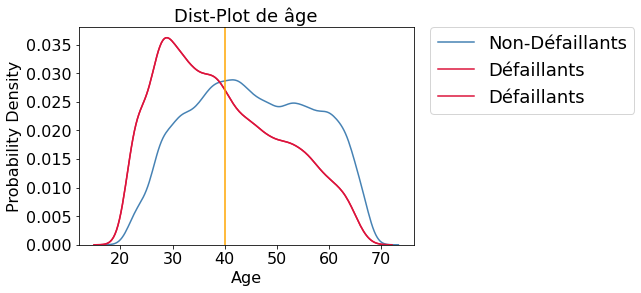

In [131]:
sns.distplot(df_dashboard['YEAR_BIRTH'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 0],
             label='Non-Défaillants', hist=False, color='SteelBlue')
sns.distplot(df_dashboard['YEAR_BIRTH'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
sns.distplot(df_dashboard['YEAR_BIRTH'][df_dashboard[
    'PRED_CLASSE_CLIENT'] == 1],
             label='Défaillants', hist=False, color='Crimson')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)
plt.title("Dist-Plot de âge", fontsize=18)
plt.axvline(x=40,color='orange')
plt.show()

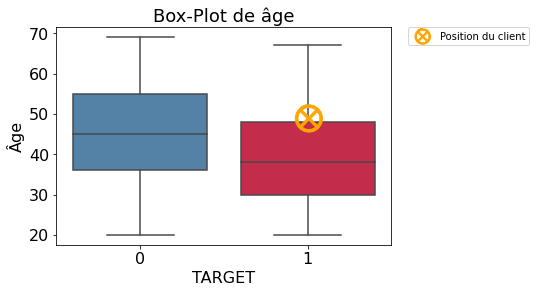

In [177]:
sns.boxplot(x='PRED_CLASSE_CLIENT',
            y='YEAR_BIRTH',
            data=df_dashboard,
            palette=['SteelBlue', 'Crimson'])
plt.title("Box-Plot de âge", fontsize=18)
plt.xlabel('TARGET', fontsize=16)
plt.ylabel('Âge', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['YEAR_BIRTH'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
import matplotlib.lines as mlines
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

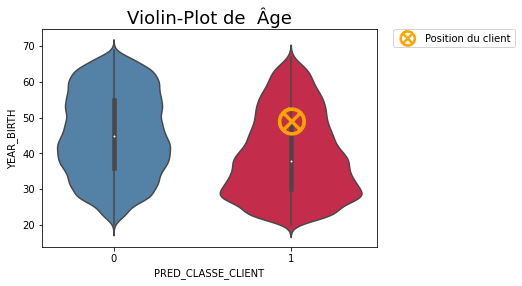

In [130]:
sns.violinplot(x='PRED_CLASSE_CLIENT', y='YEAR_BIRTH',
               data=df_dashboard,
               palette=['SteelBlue', 'Crimson'])
plt.title("Violin-Plot de  Âge", fontsize=18)
df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['YEAR_BIRTH'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.plot(df_data_applicant.loc[this_client, f], y_plot, color="blue", marker="*", markersize=20)   
plt.show()

### <span style='background:PowderBlue'>5.3. Score du client</span>

**Jauge pour le score du client**

[Source_plotly_jauge](https://plotly.com/python/gauge-charts/)

In [136]:
df_dashboard.columns.to_list()

['SK_ID_CURR',
 'PRED_CLASSE_CLIENT',
 'SCORE_CLIENT',
 'SCORE_CLIENT_%',
 'CREDIT_ANNUITY_RATIO',
 'PREV_APP_AMT_ANNUITY_MEAN',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'PREV_APP_AMT_ANNUITY_MIN',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_DOCUMENT_3',
 'EXT_SOURCE_SUM',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'BUREAU_DAYS_CREDIT_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'FLAGS_DOCUMENTS_SUM',
 'INST_PAY_AMT_INSTALMENT_MIN',
 'ENQ_CREDIT_RATIO',
 'NAME_INCOME_TYPE_WORKING',
 'BUREAU_CREDIT_TYPE_MORTGAGE_MEAN',
 'INST_PAY_DAYS_INSTALMENT_MAX',
 'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
 'POS_CASH_SK_DPD_DEF_MEAN',
 'NAME_FAMILY_STATUS_MARRIED',
 'FLAG_OWN_CAR',
 'PREV_APP_CNT_PAYMENT_MEAN',
 'OWN_CAR_AGE',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'INST_PAY_AMT_PAYMENT_DIFF_MEAN',
 'REGI

In [135]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    # Score du client df_dashboard['SCORE_CLIENT']
    value = 71,  
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "Crédit score du client", 'font': {'size': 24}},
    # Score des 20 voisins df_dashboard['SCORE_20_VOISINS_MEAN']
    delta = {'reference': 76,
             'increasing': {'color': "RebeccaPurple"}},
    gauge = {
        'axis': {'range': [None, 500], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "darkblue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
        'steps': [
            {'range': [0, 250], 'color': 'cyan'},
            {'range': [250, 400], 'color': 'royalblue'}],
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': 490}}))

fig.update_layout(paper_bgcolor = "white", font = {'color': "darkblue", 'family': "Arial"})

fig.show()

In [ ]:
109458

In [ ]:
77677

In [106]:
train_set.iloc[109458]['DAYS_EMPLOYED']

-5452.0

In [107]:
train_set.iloc[77677]['DAYS_EMPLOYED']

-5108.0

In [ ]:
df_voisin_train['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_voisin_train['DAYS_EMPLOYED'] / 365)).astype('int8')

In [109]:
np.trunc(np.abs(-5452.0/ 365))

14.0

### <span style='background:PowderBlue'>5.4. </span>